# The concept of `Activity Flow` mapping

Network coding model
<img src="img/model.png" alt="drawing" width="1200"/>


Activity Flow as a linking principle between connectivity and activity

<img src="img/concept.png" alt="drawing" width="1200"/>

## Introduction to ActivityFlow mapping 

In this tutorial, I've tried to use **only 3 packages** (*Trinity of scientific computing!!*) to perform the example tutorial. 
- `numpy` for numerical calculation
- `matplotlib` for visualization
- `scipy` for statistics

Additionally, because of example data format, you also need `h5py` to read the data. Also, you can use more fancy and handy packages to make it easy-to-read version.

You can find more easygoing version from ColaLab( https://github.com/ColeLab/ActflowToolbox) for end-users.

### Import the modules will be using for this tutorial

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import h5py 

subj_list = ['100206','108020','117930','126325','133928','143224',
             '153934','164636','174437','183034','194443','204521',
             '212823','268749','322224','385450','463040','529953',
             '587664','656253','731140','814548','877269','978578',
             '100408','108222','118124','126426','134021','144832']


### Cortical network parcellation
The HCP’s multi-modal parcellation, version 1.0 (HCP_MMP1.0) 

See more in Glasser et al., 2016, http://doi.org/10.1038/nature18933

*You don't need to run this code! It's not essential step to proceed the tutorial.*

/Users/jwpark/opt/anaconda3/envs/ActivityFlow_tutorial/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "



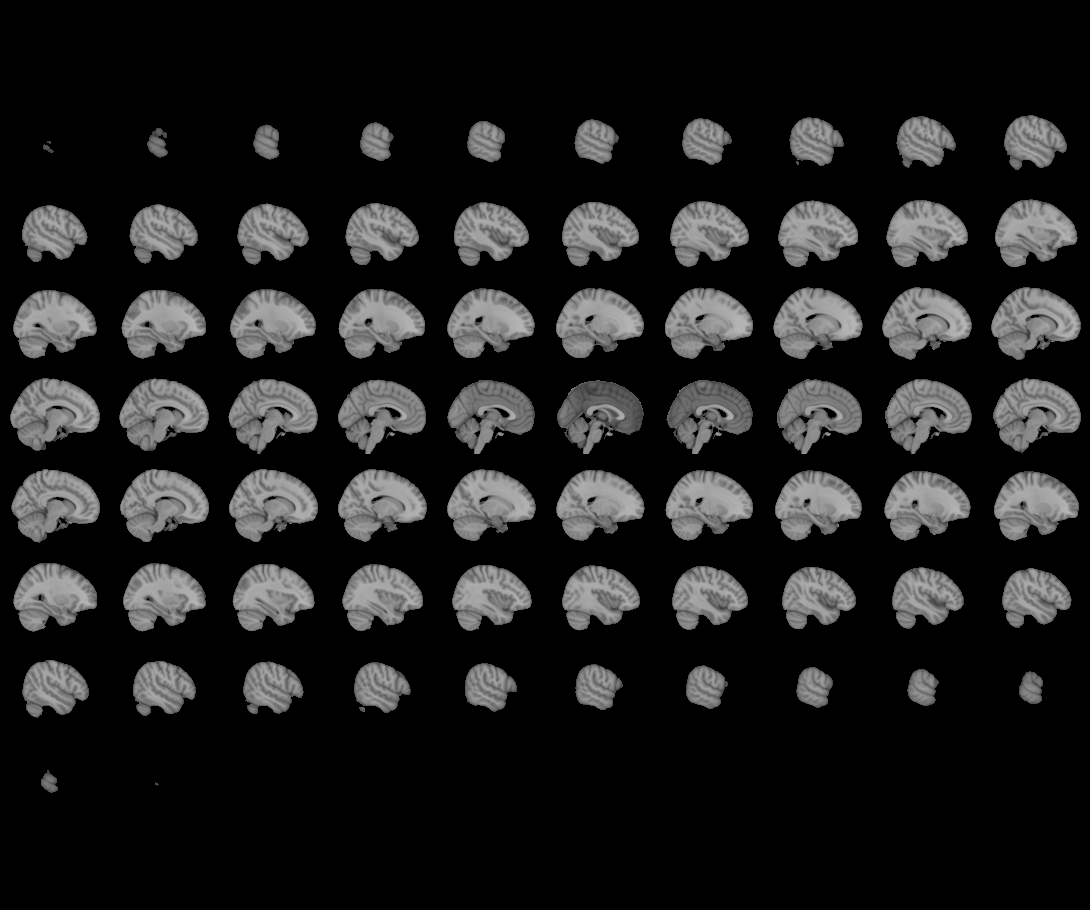
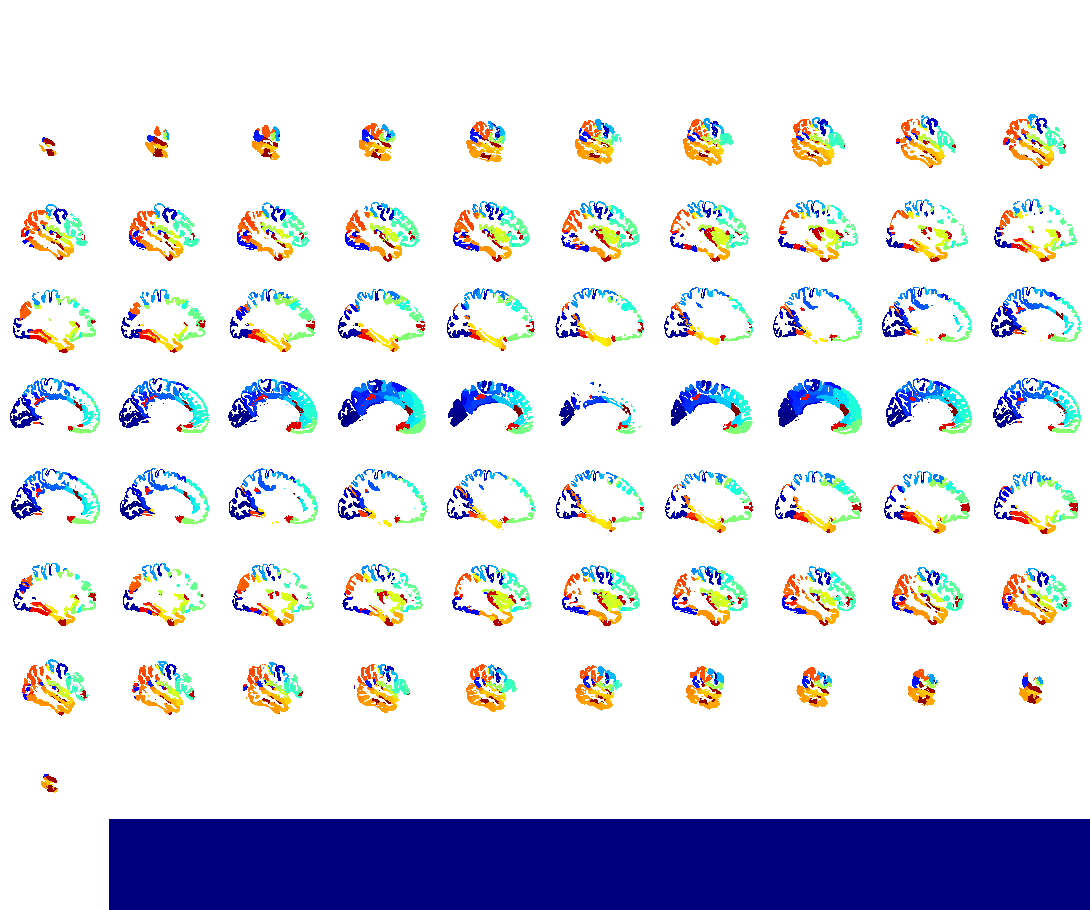

In [2]:
# PLEASE! do not try this.

# import nibabel as nib
# from nilearn import plotting
# cortical_atlas_image = nib.load('HCPMMP1_on_MNI152_ICBM2009a_nlin.nii.gz')
# cortical_atlas_data = np.ceil(cortical_atlas_image.get_fdata()).astype(int)
# plotting.view_img(cortical_atlas_image, symmetric_cmap=False, cmap='jet')

### Network-level partition
Ji et al., (2019) https://doi.org/10.1016/j.neuroimage.2018.10.006
![title](img/CABNP_cortex.png)

In [3]:
network_assignment = np.genfromtxt('cortex_parcel_network_assignments.txt')
network_order = np.argsort(network_assignment)
network_labels = ['VIS1','VIS2','SMN','CON','DAN','LAN',
                  'FPN','AUD','DMN','PMM','VMM','ORA']

# VIS1: primary visual
# VIS2: secondary visual
# SMN: somatomotor
# CON: cingulo-opercular
# DAN: dorsal attention
# LAN: language
# FPN: frontoparietal
# AUD: auditory
# DMN: default-mode
# PMM: posterior multimodal
# VMM: vental multimodel
# OAN: orbito-affective

### Load Resting-fMRI data
Example data from: https://www.humanconnectome.org/study/hcp-young-adult
- Total 30 subjects
- single run of resting fMRI(1195 TRs)
- Preprocess pipelines are described here: https://doi.org/10.1101/560730
- Cortical network parcellation from HCP_MMP

In [4]:
num_rois = 360         # Number of cortical parcels(Cole-Anticevic network parcellation)
num_timepoints = 1195  # Resting TRs
num_subjects = len(subj_list)

fMRI_resting = np.zeros((num_rois, num_timepoints, num_subjects))

for s, subj in enumerate(subj_list):
    fname = 'HCP_example_data/HCP_example_restrun1_subj' + subj + '_data' + '.h5'
    h5f = h5py.File(fname, 'r')
    dataid = 'restdata'
    fMRI_resting[:,:,s] = h5f[dataid][:]
    h5f.close()
    
print('Loaded fMRI resting data: ', fMRI_resting.shape) # should be (360, 1195, 30)

Loaded fMRI resting data:  (360, 1195, 30)


### Load Task-fMRI data (activation map only)
- Activation map was defiend by task-GLM
- 24 Structured cognitive tasks
- See more in https://www.biorxiv.org/content/10.1101/560730v3.full.pdf

In [5]:
fname= 'HCP_example_data/HCP_example_taskactivations_data.h5'
h5f = h5py.File(fname,'r')
fMRI_task = h5f['taskbeta'][:]
h5f.close()

num_tasks = 24
print('Loaded fMRI task activation data: ', fMRI_task.shape)
# Should be (360, 24, 30) each represents (num_rois, num_tasks, num_subjects)

task_conditions = ['EMOTION:fear',
                   'EMOTION:neut',
                   'GAMBLING:win',
                   'GAMBLING:loss',
                   'LANGUAGE:story',
                   'LANGUAGE:math',
                   'MOTOR:cue',
                   'MOTOR:lf',
                   'MOTOR:rf',
                   'MOTOR:lh',
                   'MOTOR:rh',
                   'MOTOR:t',
                   'REASONING:rel',
                   'REASONING:mat',
                   'SOCIAL:mental',
                   'SOCIAL:rnd',
                   'WM 0bk:body',
                   'WM 0bk:faces',
                   'WM 0bk:places',
                   'WM 0bk:tools',
                   'WM 2bk:body',
                   'WM 2bk:faces',
                   'WM 2bk:places',
                   'WM 2bk:tools']

Loaded fMRI task activation data:  (360, 24, 30)


### Calculate Resting FC patterns with pearson correlation

In [6]:
resting_FC = np.zeros((num_rois, num_rois, num_subjects))
for s, subj in enumerate(subj_list):
    resting_FC[:,:,s] = np.corrcoef(fMRI_resting[network_order,:,s])
print('Resting FC measured by pearson correlation: ', resting_FC.shape)

Resting FC measured by pearson correlation:  (360, 360, 30)


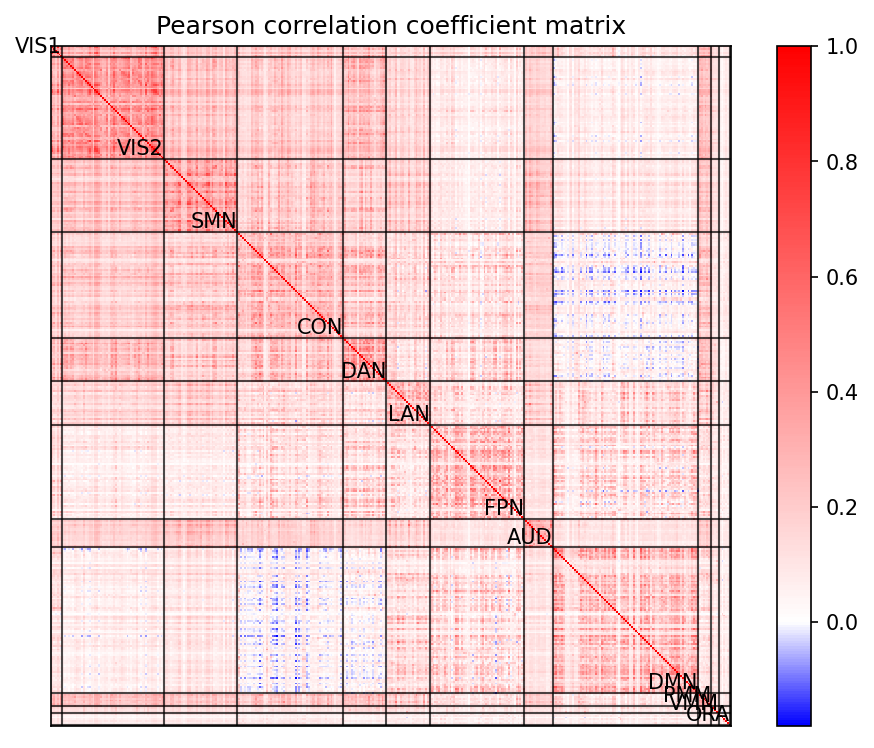

In [7]:
resting_FC_mean = np.mean(resting_FC, axis=-1) # average across subjects

divnorm=matplotlib.colors.TwoSlopeNorm(vmin=np.min(resting_FC_mean), 
                                       vcenter=0., 
                                       vmax=np.max(resting_FC_mean))

plt.figure(figsize=(8,6), dpi=150)
plt.imshow(resting_FC_mean, cmap='bwr', norm=divnorm, interpolation='none')
plt.colorbar()

roi_idx = 0
for n, label in enumerate(network_labels):
    roi_idx += np.sum(network_assignment==n+1)
    plt.axvline(roi_idx-1, c='k', lw=1, alpha=0.7)
    plt.axhline(roi_idx-1, c='k', lw=1, alpha=0.7)
    plt.text(roi_idx-1, roi_idx-1, label, ha='right', va='bottom')
    
plt.title("Pearson correlation coefficient matrix")
plt.xticks([])
plt.yticks([])
plt.show()

## Activity flow over resting state FC

In [8]:
sub = 0 #subject index to test

actual_task_activation = fMRI_task[network_order,:,sub]
predicted_task_activation = np.zeros((num_rois, num_tasks)) #ROIs, tasks

for roi in range(num_rois):
    FC_weight = resting_FC[:,roi,sub] #no meaning but conventional "from-to" indexing...
    for task in range(num_tasks):
        activity = np.dot(actual_task_activation[np.arange(num_rois)!=roi,task], 
                          FC_weight[np.arange(num_rois)!=roi]) # except roi itself...
        predicted_task_activation[roi, task] = activity
        

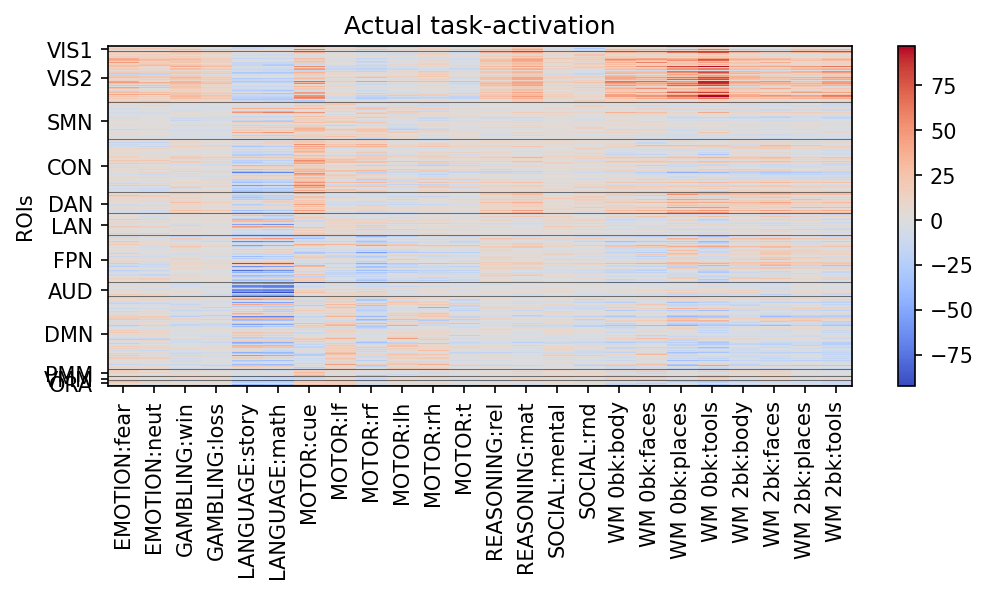

In [9]:
plt.figure(figsize=(8,3), dpi=150)
divnorm=matplotlib.colors.TwoSlopeNorm(vmin=np.min(actual_task_activation), 
                                       vcenter=0., 
                                       vmax=np.max(actual_task_activation))
plt.imshow(actual_task_activation, cmap='coolwarm', 
           norm=divnorm, aspect='auto', interpolation='none')
plt.colorbar()
plt.xticks(np.arange(num_tasks), task_conditions, rotation=90)
plt.ylabel('ROIs')

network_labels_idx = []
roi_idx = 0
for n, label in enumerate(network_labels):
    half_idx = np.sum(network_assignment==n+1)/2
    network_labels_idx.append(roi_idx+half_idx)
    roi_idx += 2*half_idx
    plt.axhline(roi_idx-1, c='k', lw=0.5, alpha=0.5)
    
    
plt.yticks(network_labels_idx, network_labels)
plt.title('Actual task-activation')
plt.show()

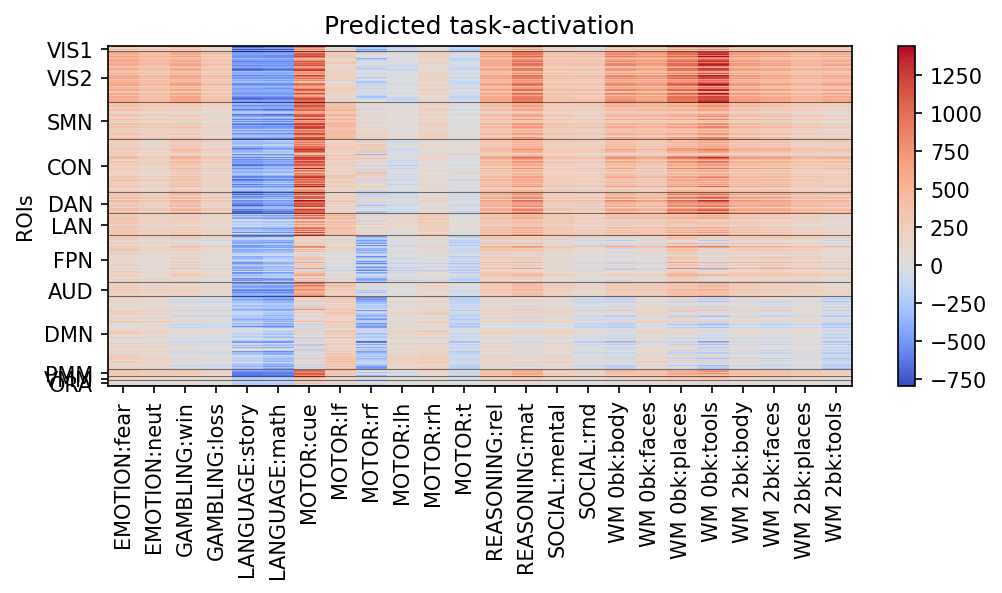

In [10]:
plt.figure(figsize=(8,3), dpi=150)
divnorm=matplotlib.colors.TwoSlopeNorm(vmin=np.min(predicted_task_activation), 
                                       vcenter=0., 
                                       vmax=np.max(predicted_task_activation))
plt.imshow(predicted_task_activation, cmap='coolwarm', 
           norm=divnorm, aspect='auto', interpolation='none')
plt.colorbar()
plt.xticks(np.arange(num_tasks), task_conditions, rotation=90)
plt.ylabel('ROIs')

network_labels_idx = []
roi_idx = 0
for n, label in enumerate(network_labels):
    half_idx = np.sum(network_assignment==n+1)/2
    network_labels_idx.append(roi_idx+half_idx)
    roi_idx += 2*half_idx
    plt.axhline(roi_idx-1, c='k', lw=0.5, alpha=0.5)
    
plt.title('Predicted task-activation')
plt.yticks(network_labels_idx, network_labels)
plt.show()

In [11]:
r_total = []
for task, task_label in enumerate(task_conditions):
    r, p = scipy.stats.pearsonr(predicted_task_activation[:,task],
                                actual_task_activation[:,task])
    r_total.append(r)
    
    print("  Task:",task_label, "\t Pearson's r={:0.3f}".format(r))

print("  ------------------------------------------")
print("  Average across tasks:  Pearson's r={:0.3f}".format(np.mean(r_total)))

  Task: EMOTION:fear 	 Pearson's r=0.529
  Task: EMOTION:neut 	 Pearson's r=0.496
  Task: GAMBLING:win 	 Pearson's r=0.695
  Task: GAMBLING:loss 	 Pearson's r=0.634
  Task: LANGUAGE:story 	 Pearson's r=0.293
  Task: LANGUAGE:math 	 Pearson's r=0.256
  Task: MOTOR:cue 	 Pearson's r=0.468
  Task: MOTOR:lf 	 Pearson's r=0.372
  Task: MOTOR:rf 	 Pearson's r=0.725
  Task: MOTOR:lh 	 Pearson's r=0.528
  Task: MOTOR:rh 	 Pearson's r=0.506
  Task: MOTOR:t 	 Pearson's r=0.644
  Task: REASONING:rel 	 Pearson's r=0.546
  Task: REASONING:mat 	 Pearson's r=0.629
  Task: SOCIAL:mental 	 Pearson's r=0.507
  Task: SOCIAL:rnd 	 Pearson's r=0.637
  Task: WM 0bk:body 	 Pearson's r=0.642
  Task: WM 0bk:faces 	 Pearson's r=0.493
  Task: WM 0bk:places 	 Pearson's r=0.580
  Task: WM 0bk:tools 	 Pearson's r=0.628
  Task: WM 2bk:body 	 Pearson's r=0.591
  Task: WM 2bk:faces 	 Pearson's r=0.546
  Task: WM 2bk:places 	 Pearson's r=0.505
  Task: WM 2bk:tools 	 Pearson's r=0.594
  ---------------------------------

## ActivityFlow over resting-state FC with partial correlation
<img src="img/combined_FC.png" alt="drawing" width="600"/>

>The pattern of spurious causal inferences for bivariate and partial correlations. Switching from correlation to partial correlation improves causal inference (but is not perfect). We propose integrating inferences from both correlation and partial correlation, which we predict will produce further improvements to causal inferences. Red lines indicate spurious causal inferences. Note that, in the case of a collider, when A → C and B → C are positive, then the spurious A–B connection induced by partial correlation will be negative

Note: This is the best recommended way to apply ActivityFlow mapping by the reference.

See for more info: Sanchez-Romero, Ruben, and Michael W. Cole. (2020). https://doi.org/10.1162/jocn_a_01580

### Step 1. Calculate partial correlation coefficient
The partial correlation coefficient(`rp`) between two nodes' A and B conditioning on **C** (**C** represents the set of all nodes except A and B) can be calculated as `rp_{A,B} = -P(A,B)/sqrt(P(AA)*P(BB)`. `P` is the precision matrix(inverse of covariance matrix). This is mathematically equivalent to computing the bivariate correlation of each pair of nodes' time series after regressing out all other nodes' time series. (See more details in Sanchez-Romero, Ruben, and Michael W. Cole., 2020)

<img src="img/partial.png" alt="drawing" width="1200"/>
Source: https://en.wikipedia.org/wiki/Partial_correlation


In [12]:
# Define the data 
sub = 0
resting_timeseries = fMRI_resting[network_order,:,0].T
print('Resting timeseries:', resting_timeseries.shape)

# calculate partial correlation using the inverse covariance method
# get precision matrix(inverse correlation)
inverse_covariance = np.linalg.pinv(np.cov(resting_timeseries, rowvar=False))
print('Precision matrix:', inverse_covariance.shape)

partial_correlation = np.zeros(inverse_covariance.shape)
for roi_A in range(num_rois):
    for roi_B in range(num_rois):
        if roi_A != roi_B:
            P_AB = inverse_covariance[roi_A, roi_B]
            P_AA = inverse_covariance[roi_A, roi_A]
            P_BB = inverse_covariance[roi_B, roi_B]
            partial_correlation[roi_A, roi_B] = -P_AB/np.sqrt(P_AA*P_BB)
            
print('Partial correlation matrix:', partial_correlation.shape)

Resting timeseries: (1195, 360)
Precision matrix: (360, 360)
Partial correlation matrix: (360, 360)


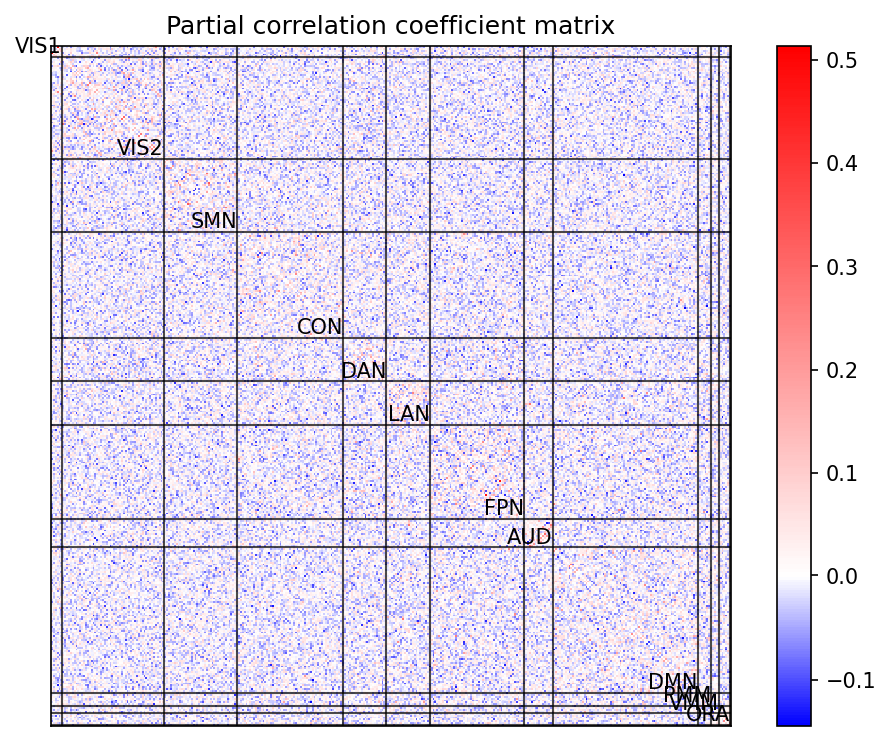

In [13]:
divnorm=matplotlib.colors.TwoSlopeNorm(vmin=np.min(partial_correlation), 
                                       vcenter=0., 
                                       vmax=np.max(partial_correlation))

plt.figure(figsize=(8,6), dpi=150)
plt.imshow(partial_correlation, cmap='bwr', norm=divnorm, interpolation='none')
plt.colorbar()

roi_idx = 0
for n, label in enumerate(network_labels):
    roi_idx += np.sum(network_assignment==n+1)
    plt.axvline(roi_idx-1, c='k', lw=1, alpha=0.7)
    plt.axhline(roi_idx-1, c='k', lw=1, alpha=0.7)
    plt.text(roi_idx-1, roi_idx-1, label, ha='right', va='bottom')
    
plt.title("Partial correlation coefficient matrix")
plt.xticks([])
plt.yticks([])
plt.show()

### Step 2. Test null hypothesis (test if partial correlation = 0)
>To determine statistical significance, the partial correlation coefficients rAB|C are transformed to the Fisher z statistic Fz = [tanh−1(rAB|C) − tanh−1(rAB|CHo)]sqrt(N − |C| − 3), where rAB|CHo is the partial correlation coefficient under the null hypothesis, N is the number of datapoints, and |C| is the number of nodes in the conditioning set C. The Fz statistic has a distribution that approximates a standard normal with a mean of 0 and a standard deviation of 1 and is used in a two-sided z test for the null hypothesis of zero partial correlation, rAB|CHo = 0, at a selected α cutoff. For Fz(α/2), the value corresponding to the α cutoff in a two-sided z test, if Fz ≥ +Fz(α/2) or Fz ≤ −Fz(α/2), the partial correlation is considered significantly different from zero and an edge between A and B is added to the initial network with a weight equal to rAB|C.

<img src="img/null_hypothesis.png" alt="drawing" width="600"/>

See more info: https://en.wikipedia.org/wiki/Partial_correlation#As_conditional_independence_test

In [14]:
level_of_significance = 0.01

# Fisher r to Z
Z = np.sqrt(num_timepoints-num_rois-3)*np.arctanh(partial_correlation)

# reject the null hypothesis if |Fz| > Z_cutoff(=2.57)
Z_cutoff = scipy.stats.norm.ppf(1-level_of_significance/2, # two-sided
                                loc=0,   # mean
                                scale=1) # standard deviation 

partial_correlation_sig = np.multiply(partial_correlation, np.abs(Z)>=Z_cutoff)


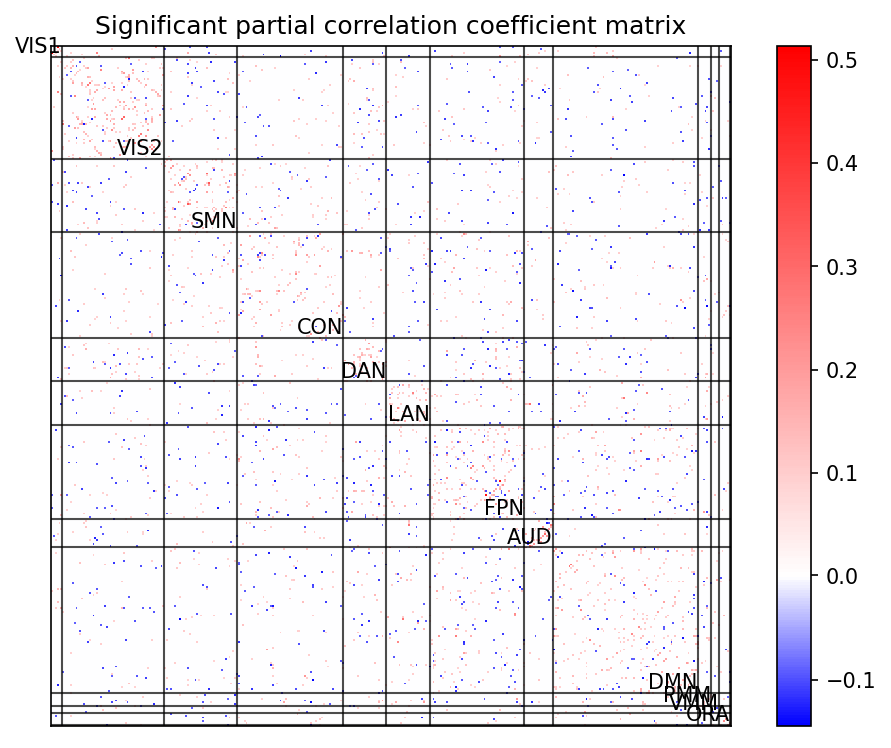

In [15]:
divnorm=matplotlib.colors.TwoSlopeNorm(vmin=np.min(partial_correlation_sig), 
                                       vcenter=0., 
                                       vmax=np.max(partial_correlation_sig))

plt.figure(figsize=(8,6), dpi=150)
plt.imshow(partial_correlation_sig, cmap='bwr', norm=divnorm, interpolation='none')
plt.colorbar()

roi_idx = 0
for n, label in enumerate(network_labels):
    roi_idx += np.sum(network_assignment==n+1)
    plt.axvline(roi_idx-1, c='k', lw=1, alpha=0.7)
    plt.axhline(roi_idx-1, c='k', lw=1, alpha=0.7)
    plt.text(roi_idx-1, roi_idx-1, label, ha='right', va='bottom')
    
plt.title("Significant partial correlation coefficient matrix")
plt.xticks([])
plt.yticks([])
plt.show()

### Step 3: Remove colider effect on partial correlation
Test if two nodes have a significant partial correlation but a not significant correlation

>To check for spurious edges caused by conditioning on a collider in the partial correlation step, the bivariate Pearson correlation coefficient rAB is computed for each pair of connected nodes A and B in the initial network. In contrast to the partial correlation step in which edges are added to the network, in the correlation step, edges are removed if rAB = 0. For bivariate correlation coefficients rAB, the above formula for Fz reduces to Fz = [tanh−1(rAB) − tanh−1(rABHo)]sqrt(N − 3), because bivariate correlation does not condition on other nodes, and so the size of the conditioning set |C| = 0. A two-sided z test for the null hypothesis of rABHo = 0 is conducted at a chosen α cutoff. For Fzα/2, the value corresponding to the α cutoff in a two-sided test, if Fz ≤ +Fz(α/2) or Fz ≥ −Fz(α/2), the bivariate correlation is considered not significantly different from zero and the corresponding edge between A and B is removed from the initial network.

In [16]:
level_of_significance = 0.01

# Fisher r to Z
correlation = resting_FC[:,:,sub]
np.fill_diagonal(correlation,0)
Z = np.sqrt(num_timepoints-3)*np.arctanh(correlation)

# reject the null hypothesis if |Fz| > Z_cutoff(=2.57)
Z_cutoff = scipy.stats.norm.ppf(1-level_of_significance/2, # two-sided
                                loc=0,   # mean
                                scale=1) # standard deviation 
correlation_sig = np.multiply(correlation, np.abs(Z)>=Z_cutoff)

combined_FC = np.copy(partial_correlation_sig)

for roi_A in range(num_rois):
    for roi_B in range(num_rois):
        if roi_A != roi_B:
            partial_correlation_coefficient = partial_correlation_sig[roi_A, roi_B]
            correlation_coefficient = correlation_sig[roi_A, roi_B]
            
            # Test if there's no significant correlation
            if partial_correlation_coefficient!=0 and correlation_coefficient==0:
                combined_FC[roi_A, roi] = 0

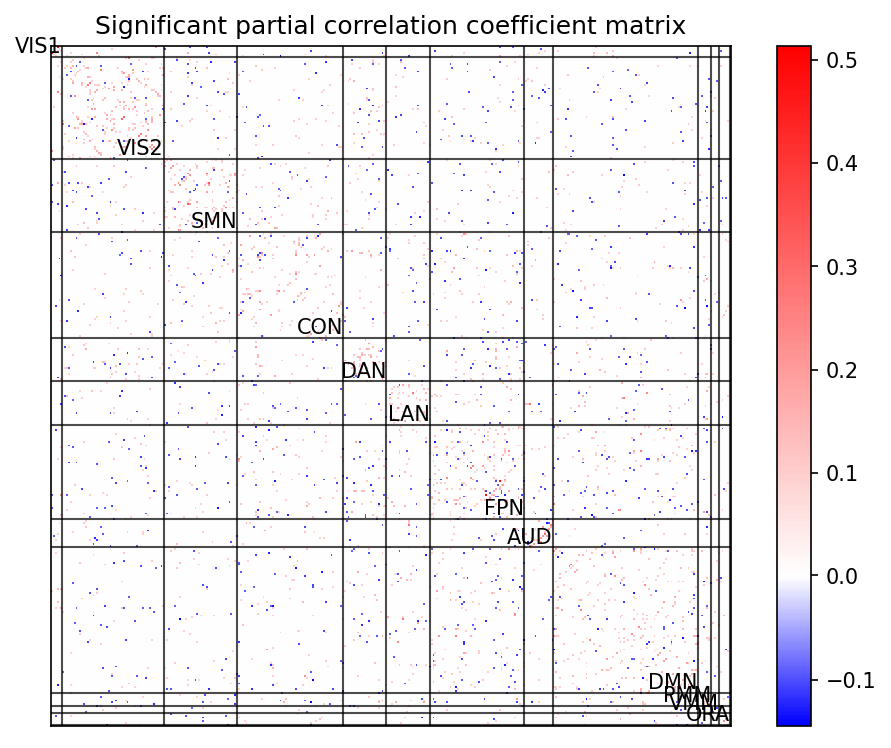

In [17]:
divnorm=matplotlib.colors.TwoSlopeNorm(vmin=np.min(combined_FC), 
                                       vcenter=0., 
                                       vmax=np.max(combined_FC))

plt.figure(figsize=(8,6), dpi=150)
plt.imshow(combined_FC, cmap='bwr', norm=divnorm, interpolation='none')
plt.colorbar()

roi_idx = 0
for n, label in enumerate(network_labels):
    roi_idx += np.sum(network_assignment==n+1)
    plt.axvline(roi_idx-1, c='k', lw=1, alpha=0.7)
    plt.axhline(roi_idx-1, c='k', lw=1, alpha=0.7)
    plt.text(roi_idx-1, roi_idx-1, label, ha='right', va='bottom')
    
plt.title("Significant partial correlation coefficient matrix")
plt.xticks([])
plt.yticks([])
plt.show()

### Step 4. Calculate ActivityFlow effect on combined FC

In [18]:
sub = 0 #subject index to test

actual_task_activation_ = fMRI_task[network_order,:,sub]
predicted_task_activation_combined_FC = np.zeros((num_rois, num_tasks)) #ROIs, tasks

for roi in range(num_rois):
    combined_FC_weight = combined_FC[:,roi] # we got combined FC only for sub=0 
    for task in range(num_tasks):
        activity = np.dot(actual_task_activation[np.arange(num_rois)!=roi,task], 
                          combined_FC_weight[np.arange(num_rois)!=roi]) # except roi itself...
        predicted_task_activation_combined_FC[roi, task] = activity
        

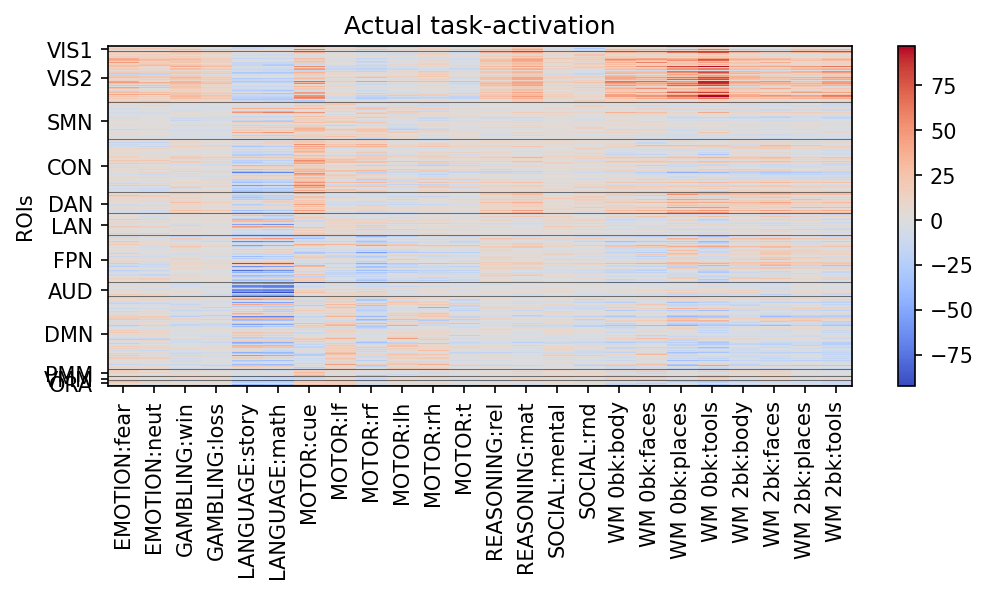

In [19]:
plt.figure(figsize=(8,3), dpi=150)
divnorm=matplotlib.colors.TwoSlopeNorm(vmin=np.min(actual_task_activation), 
                                       vcenter=0., 
                                       vmax=np.max(actual_task_activation))
plt.imshow(actual_task_activation, cmap='coolwarm', 
           norm=divnorm, aspect='auto', interpolation='none')
plt.colorbar()
plt.xticks(np.arange(num_tasks), task_conditions, rotation=90)
plt.ylabel('ROIs')

network_labels_idx = []
roi_idx = 0
for n, label in enumerate(network_labels):
    half_idx = np.sum(network_assignment==n+1)/2
    network_labels_idx.append(roi_idx+half_idx)
    roi_idx += 2*half_idx
    plt.axhline(roi_idx-1, c='k', lw=0.5, alpha=0.5)
    
    
plt.yticks(network_labels_idx, network_labels)
plt.title('Actual task-activation')
plt.show()

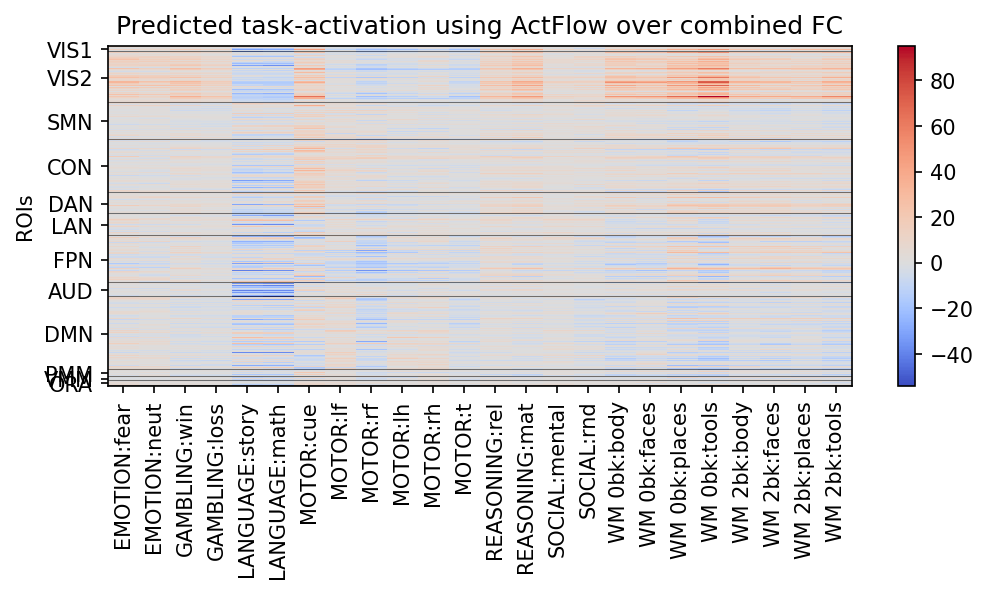

In [20]:
plt.figure(figsize=(8,3), dpi=150)
divnorm=matplotlib.colors.TwoSlopeNorm(vmin=np.min(predicted_task_activation_combined_FC), 
                                       vcenter=0., 
                                       vmax=np.max(predicted_task_activation_combined_FC))
plt.imshow(predicted_task_activation_combined_FC, cmap='coolwarm', 
           norm=divnorm, aspect='auto', interpolation='none')
plt.colorbar()
plt.xticks(np.arange(num_tasks), task_conditions, rotation=90)
plt.ylabel('ROIs')

network_labels_idx = []
roi_idx = 0
for n, label in enumerate(network_labels):
    half_idx = np.sum(network_assignment==n+1)/2
    network_labels_idx.append(roi_idx+half_idx)
    roi_idx += 2*half_idx
    plt.axhline(roi_idx-1, c='k', lw=0.5, alpha=0.5)
    
plt.title('Predicted task-activation using ActFlow over combined FC')
plt.yticks(network_labels_idx, network_labels)
plt.show()

In [21]:
r_total = []
for task, task_label in enumerate(task_conditions):
    r, p = scipy.stats.pearsonr(predicted_task_activation_combined_FC[:,task],
                                actual_task_activation[:,task])
    r_total.append(r)
    
    print("  Task:",task_label, "\t Pearson's r={:0.3f}".format(r))

print("  ------------------------------------------")
print("  Average across tasks:  Pearson's r={:0.3f}".format(np.mean(r_total)))
# Note: Predictive power of subject 0 using resting-FC was 0.543

  Task: EMOTION:fear 	 Pearson's r=0.647
  Task: EMOTION:neut 	 Pearson's r=0.612
  Task: GAMBLING:win 	 Pearson's r=0.731
  Task: GAMBLING:loss 	 Pearson's r=0.704
  Task: LANGUAGE:story 	 Pearson's r=0.599
  Task: LANGUAGE:math 	 Pearson's r=0.588
  Task: MOTOR:cue 	 Pearson's r=0.653
  Task: MOTOR:lf 	 Pearson's r=0.545
  Task: MOTOR:rf 	 Pearson's r=0.674
  Task: MOTOR:lh 	 Pearson's r=0.570
  Task: MOTOR:rh 	 Pearson's r=0.546
  Task: MOTOR:t 	 Pearson's r=0.693
  Task: REASONING:rel 	 Pearson's r=0.687
  Task: REASONING:mat 	 Pearson's r=0.717
  Task: SOCIAL:mental 	 Pearson's r=0.551
  Task: SOCIAL:rnd 	 Pearson's r=0.707
  Task: WM 0bk:body 	 Pearson's r=0.741
  Task: WM 0bk:faces 	 Pearson's r=0.625
  Task: WM 0bk:places 	 Pearson's r=0.697
  Task: WM 0bk:tools 	 Pearson's r=0.749
  Task: WM 2bk:body 	 Pearson's r=0.712
  Task: WM 2bk:faces 	 Pearson's r=0.689
  Task: WM 2bk:places 	 Pearson's r=0.668
  Task: WM 2bk:tools 	 Pearson's r=0.724
  ---------------------------------

## Discussion and open questions

- **Most important! - What did we learn and what can we do using this?**
- Is it a *good* approach to understand distributed coding across large-scale functional networks? 
- Is there something technically or logically incorrect? (are the brain regions completely separated?)
- What will be the result if we use/start *activity* only from the sensory networks?
- What will happen if we ignore all ROIs within the same functional network?